In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/Colab\ Notebooks/MIMO

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/MIMO


In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import scipy.io as sio
from torchsummary import summary

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
import pdb

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


## Utilities

In [3]:
from numpy.linalg import norm,solve,inv

def getH(M):
    return np.conjugate(M).T

def NMSE(H, H_cap):
    diff = H_cap - H
    return (norm(diff)**2/norm(H)**2)

def denoise(img_noisy_var,k=8,numit = 1800,rn = 0.0,find_best=True,upsample_first = True):
    num_channels = [k]*5
    net = decodernw(output_depth,num_channels_up=num_channels,upsample_first=upsample_first,need_sigmoid=False).type(dtype)
    #summary(net, (k,2,2))
    #pdb.set_trace()
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        num_iter=numit,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        find_best=find_best
                        )
    out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]
    return out_img_np, mse_t

In [4]:
H_org = sio.loadmat("H_64x64x64_EPA.mat")
# interference = sio.loadmat("interference.mat")
# int_extracted = interference['interference']
array = ['noisy_0dB', 'noisy_5dB', 'noisy_10dB', 'noisy_15dB', 'noisy_20dB']
length = 20
snrs = [0,5,10,15,20];
Nsub = 64
Nr = 64

In [22]:
vect_noise = np.zeros((64,64,64,len(array),length),dtype=complex)
Niter = {8:4000, 16:1970, 32:1800, 64:1000}
dd_errors = {}

for Ns in [16]:
    print('k = ',Ns)
    dd_errors[Ns] = np.zeros((length, len(array)))
    for k in range(length): 
        print(k,end= ' ')
        K = k
        H_extracted = H_org['noiseless']
        H_clean = H_extracted[:,0,:,K].reshape(64*64,1)
        img_np_real = np.real(H_extracted[:,:,:,k])
        img_np_imag = np.imag(H_extracted[:,:,:,k])
        img_np = np.zeros((128,64,64))
        img_np[0:64,:,:,] = np.transpose(img_np_real,(2,0,1))
        img_np[64:128,:,:] = np.transpose(img_np_imag,(2,0,1))
        img_clean_var = np_to_var(img_np).type(dtype)
        output_depth = img_np.shape[0] 
        # print("Image size: ", img_np.shape)
        i = 0
        for noise_level in array:
            print(noise_level, end=' ')
            H_extracted = H_org[noise_level]
            img_noisy_np_real = np.real(H_extracted[:,:,:,0,k])#+ int_extracted[:,:,:,k])
            img_noisy_np_imag = np.imag(H_extracted[:,:,:,0,k])# + int_extracted[:,:,:,k])
            img_noisy_np = np.zeros((128,64,64))
            img_noisy_np[0:64,:,:] = np.transpose(img_noisy_np_real,(2,0,1))
            img_noisy_np[64:128,:,:] = np.transpose(img_noisy_np_imag,(2,0,1))
            img_noisy_var = np_to_var(img_noisy_np).type(dtype)
            
            out_img_np, mse_t = denoise(img_noisy_var,k=Ns,numit = Niter[Ns],rn = 0.0)
            img_np_real_allcol = np.transpose(out_img_np[0:64,:,:],(1,2,0)) 
            img_np_imag_allcol = np.transpose(out_img_np[64:128,:,:],(1,2,0))
            img_np_real = np.reshape(img_np_real_allcol,(64,64,64))
            img_np_imag = np.reshape(img_np_imag_allcol,(64,64,64))
            vect_noise[:,:,:,i,k] = np.array(img_np_real+1j*img_np_imag,dtype=complex)
            dd_errors[Ns][k][i] = NMSE(H_clean ,vect_noise[:,0,:,i,K].reshape(64*64,1))
            i = i+1
        print('')
# dd_store = {}
# for k in dd_errors:
#     dd_store['k = '+str(k)] = dd_errors[k] 
# sio.savemat('./MIMO_dd_errors.mat', dd_store)

k =  16
0 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
1 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
2 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
3 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
4 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
5 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
6 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
7 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
8 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
9 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
10 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
11 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
12 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
13 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
14 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
15 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
16 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
17 noisy_0dB noisy_5dB noisy_10dB

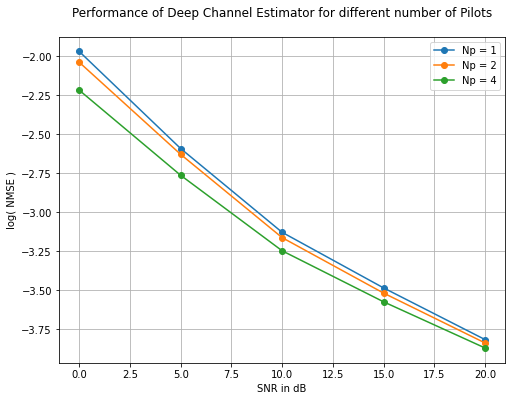

In [31]:
np_errors = {}
H_extracted = H_org['noiseless']
plt.figure(figsize=(8,6))

for Np in [1,2,4]:
    np_errors[Np] = np.zeros((20,5))
    for K in range(20):
        H_clean = H_extracted[:,0,:,K].reshape(64*64,1)
        for i in range(5):
            H_cap = np.zeros((64*64,1))
            for u in range(0,8*Np,8):
                H_cap = H_cap + vect_noise[:,u,:,i,K].reshape(64*64,1)
            H_cap = H_cap/Np
            np_errors[Np][K][i] = NMSE(H_clean, H_cap)

    plt.plot(snrs, np.log10(np.mean(np_errors[Np][:][:], axis=0)),'-o', label="Np = "+str(Np))

plt.title("Performance of Deep Channel Estimator for different number of Pilots",pad=20)
plt.xlabel("SNR in dB")
plt.ylabel("log( NMSE )")
plt.grid()
plt.legend()
plt.show()